In [1]:
from __future__ import print_function, division

In [2]:
import os
cwd = os.getcwd()
cwd

'/Users/Chuoran/DataScience/Metis/Projects'

In [3]:
## iterate through files to cut out time related information
import glob
import pandas as pd

stationlist = ['34 ST-PENN STA','TIMES SQ-42 ST','RIT-ROOSEVELT','LEXINGTON AVE']
# stationlist = ['34 ST-PENN STA']
files = glob.glob("now_to_15-01-03/*.txt")

In [4]:
fileNum = 0
todAll = pd.DataFrame()

for fle in files:
#    print(fle)   ## check file progress
    tt = pd.read_csv(fle)
    fileNum += 1
    
    tt.columns = [col.strip() for col in tt.columns]
    tt.drop(['Unnamed: 0','DIVISION'], axis = 1, inplace = True)
    tt = tt[tt['STATION'].isin(stationlist)]
    tt = tt[tt['DESC'] == 'REGULAR']
    todAll = pd.concat([todAll, tt])
    
todAll.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 866863 entries, 0 to 198418
Data columns (total 10 columns):
C/A         866863 non-null object
UNIT        866863 non-null object
SCP         866863 non-null object
STATION     866863 non-null object
LINENAME    866863 non-null object
DATE        866863 non-null object
TIME        866863 non-null object
DESC        866863 non-null object
ENTRIES     866863 non-null int64
EXITS       866863 non-null int64
dtypes: int64(2), object(8)
memory usage: 72.8+ MB


In [5]:
from copy import deepcopy

tod = deepcopy(todAll.iloc[:,:])

tod['ID'] = tod['C/A']+tod['UNIT']+tod['SCP']+tod['STATION']+tod['LINENAME']


temp = deepcopy(tod)


In [6]:
import dateutil
import datetime
from dateutil import parser
toDate = lambda x: dateutil.parser.parse(x)   

In [7]:
temp['DT'] = temp['DATE'] + ' '+ temp['TIME']
temp['DT'] = temp['DT'].apply(toDate)
temp = temp[temp['DT'].apply(lambda x: x.minute == 0 & x.second ==0)]
temp['WD'] = temp['DT'].apply(lambda x: x.weekday()<5)

In [8]:
## Add time interval at each turnstile level

import numpy as np

temp.sort_values(['STATION','LINENAME','ID','DATE','TIME'], inplace = True)

temp.drop_duplicates(subset=["ID","DT"], inplace=True)

# temp['Interval'] = (temp['DT'].diff())/ datetime.timedelta(hours=1)

temp['Interval'] = (temp.groupby(['STATION','LINENAME','ID','DATE'])
                    .DT
                    .transform(lambda grp: grp.diff()))

In [9]:
temp.sort_values(['STATION','LINENAME','ID','DATE','TIME'], inplace = True)

temp['Interval'] = temp['Interval'].apply(lambda x: x/datetime.timedelta(hours=1) if not pd.isnull(x) else np.nan)

In [10]:
temp1 = deepcopy(temp)

In [11]:
def clean_entry (row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        counter = -counter
    if counter > max_counter:
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:        # Check it again to make sure we are not giving a counter that's too big
        return 0
    return counter

def clean_exit (row, max_counter):
    counter = row["EXITS"] - row["PREV_EXITS"]
    if counter < 0:
        counter = -counter
    if counter > max_counter:
        counter = min(row["EXITS"], row["PREV_EXITS"])
    if counter > max_counter:        # Check it again to make sure we are not giving a counter that's too big
        return 0
    return counter

In [12]:
temp1.sort_values(['STATION','LINENAME','ID','DATE','TIME'], inplace = True)

temp1["PREV_ENTRIES"] = temp1.ENTRIES.shift()
temp1['PREV_EXITS'] = temp1.EXITS.shift()

temp1['I_Entries']= temp1.apply(clean_entry, axis = 1, max_counter=1000000)/temp1['Interval']
temp1['I_Exits']= temp1.apply(clean_exit, axis = 1, max_counter=1000000)/temp1['Interval']

In [13]:
temp2 = temp1.dropna(subset=['I_Entries','I_Exits'],)

In [14]:
temp2.TIME = temp2.TIME.apply(lambda x: int(x[:2]))
temp3 = temp2

/Users/Chuoran/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:2999: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [15]:
final = (temp3.groupby(['STATION','LINENAME','WD','TIME'])[['ID','Interval','DATE','I_Entries','I_Exits']]
              .agg({'ID':'nunique','Interval':'mean','DATE':'count','I_Entries':'mean','I_Exits':'mean',})
              .reset_index().sort_values(['STATION','LINENAME','WD','TIME']))

In [16]:
def wd(x):
    if x:
        return 'Weekday'
    else:
        return 'Weekend'

final.WD = final.WD.apply(lambda x: wd(x))

In [17]:
final = final.drop(36)
final

,STATION,LINENAME,WD,TIME,ID,Interval,DATE,I_Entries,I_Exits
0,34 ST-PENN STA,123,Weekend,3,21,3.000000,42,18.301587,12.420635
1,34 ST-PENN STA,123,Weekend,4,21,4.000000,3813,8.312549,5.157094
2,34 ST-PENN STA,123,Weekend,7,21,4.000000,1929,3.549896,4.355495
3,34 ST-PENN STA,123,Weekend,8,21,4.021711,3869,5.175304,7.989823
4,34 ST-PENN STA,123,Weekend,11,21,4.066398,1988,15.724095,29.280873
5,34 ST-PENN STA,123,Weekend,12,21,4.029212,3834,21.108209,38.781886
6,34 ST-PENN STA,123,Weekend,15,21,4.000000,1988,40.046152,56.504527
7,34 ST-PENN STA,123,Weekend,16,21,4.038342,3860,42.835946,56.680991
8,34 ST-PENN STA,123,Weekend,19,21,4.002012,1988,61.593498,62.794957
9,34 ST-PENN STA,123,Weekend,20,21,4.021711,3869,56.236129,57.313658


34 ST-PENN STA 123 Weekend (11, 9)
34 ST-PENN STA 123 Weekday (11, 9)
34 ST-PENN STA 123ACE Weekend (11, 9)
34 ST-PENN STA 123ACE Weekday (12, 9)
34 ST-PENN STA ACE Weekend (11, 9)
34 ST-PENN STA ACE Weekday (13, 9)
LEXINGTON AVE F Weekend (11, 9)
LEXINGTON AVE F Weekday (10, 9)
LEXINGTON AVE NQR456 Weekend (11, 9)
LEXINGTON AVE NQR456 Weekday (10, 9)
RIT-ROOSEVELT R Weekend (10, 9)
RIT-ROOSEVELT R Weekday (10, 9)
TIMES SQ-42 ST 1237ACENQRS Weekend (11, 9)
TIMES SQ-42 ST 1237ACENQRS Weekday (11, 9)
TIMES SQ-42 ST 1237ACENQRSW Weekend (11, 9)
TIMES SQ-42 ST 1237ACENQRSW Weekday (10, 9)
TIMES SQ-42 ST ACENQRS1237 Weekend (10, 9)
TIMES SQ-42 ST ACENQRS1237 Weekday (10, 9)
TIMES SQ-42 ST ACENQRS1237W Weekend (11, 9)
TIMES SQ-42 ST ACENQRS1237W Weekday (10, 9)


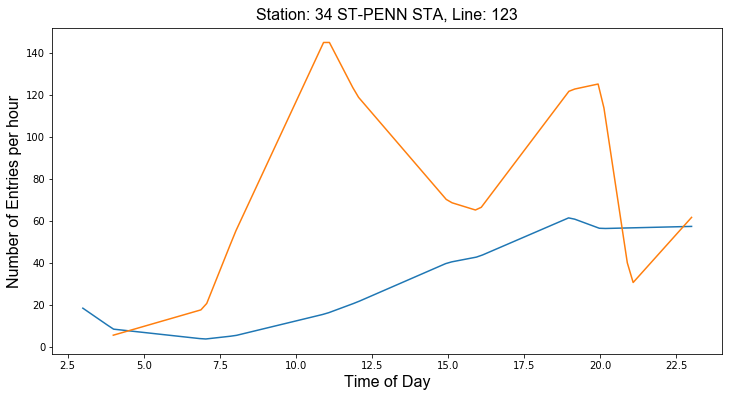

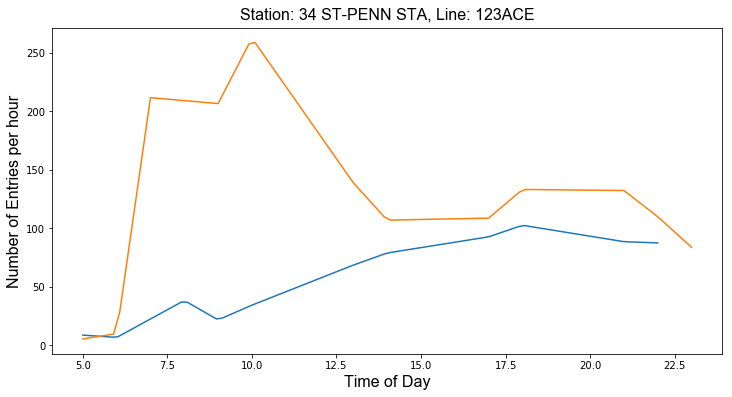

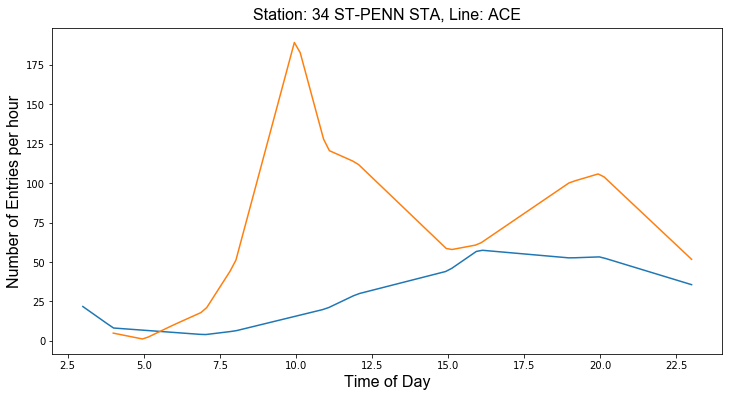

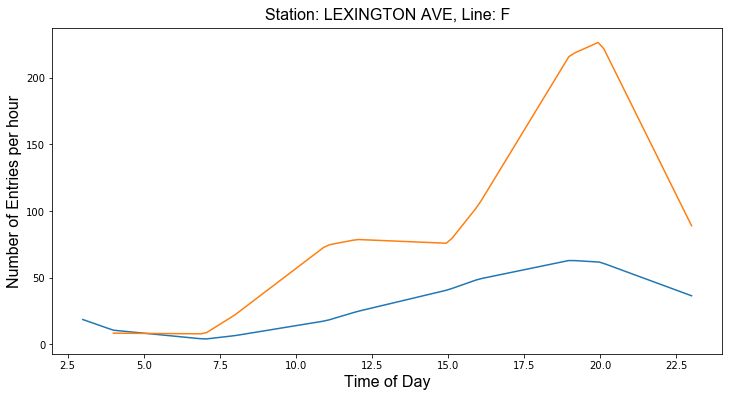

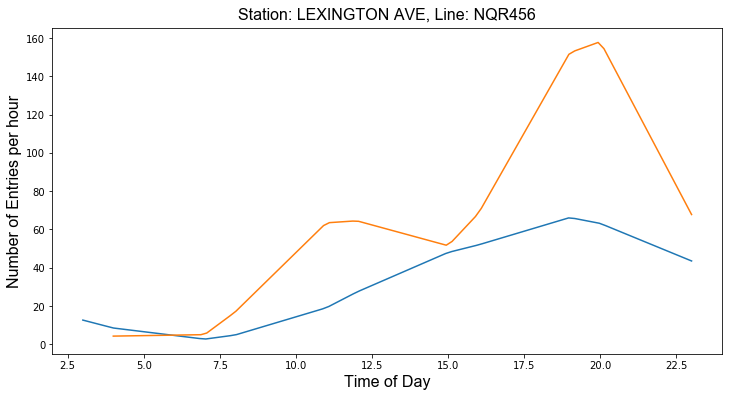

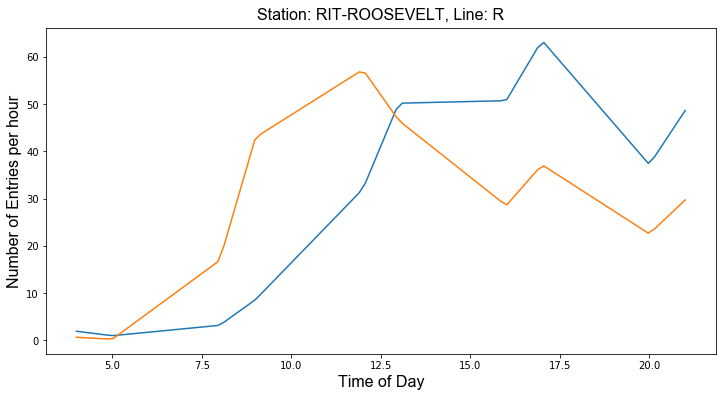

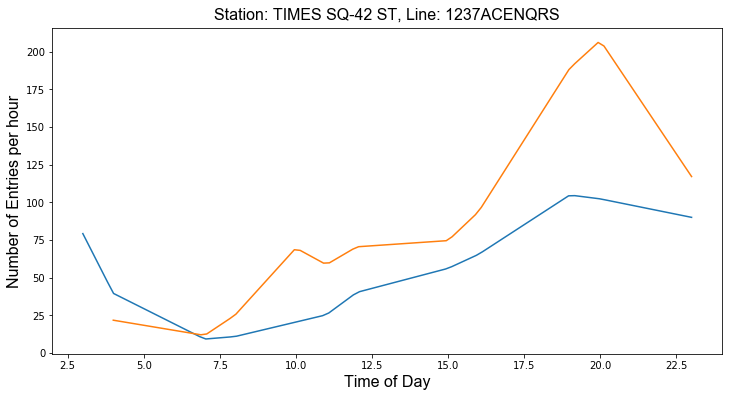

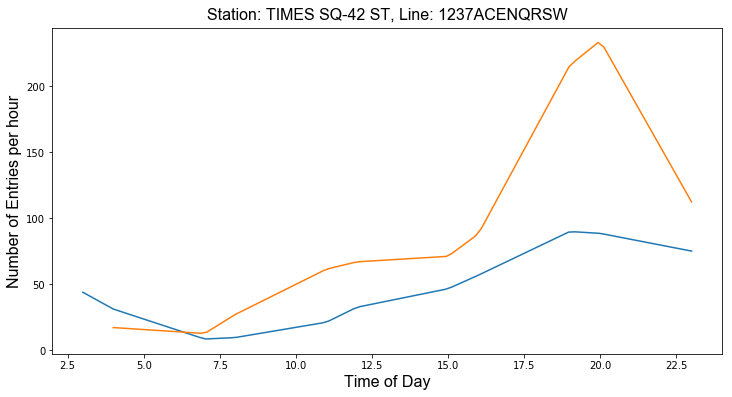

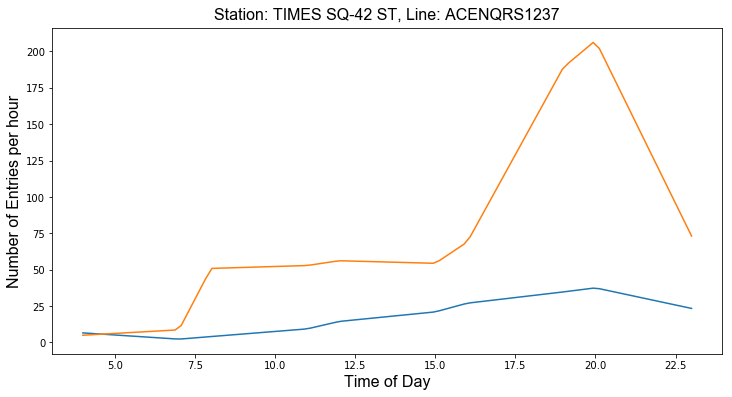

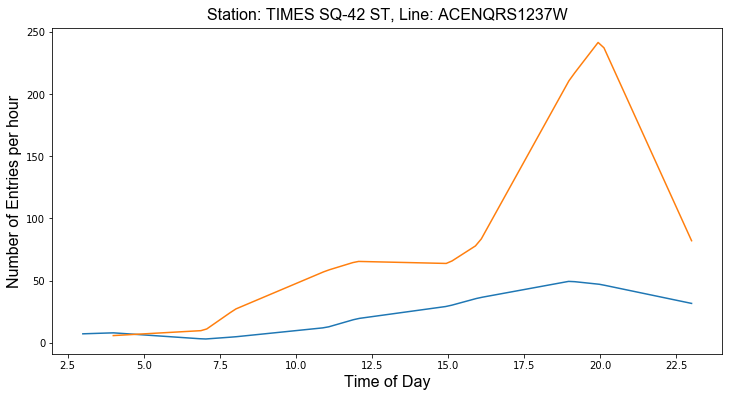

In [28]:
import scipy as sp
from scipy.interpolate import interp1d
import matplotlib.font_manager as font_manager

import matplotlib
from matplotlib import pyplot as plt
from IPython.display import Image

%matplotlib inline

title_font = {'fontname':'Arial', 'size':'16', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'Arial', 'size':'16'}


for sta in final.STATION.unique():
    for line in final[final.STATION == sta].LINENAME.unique():
        plt.figure(figsize=(12,6))
        for day in final.WD.unique():
            forplot = final[(final.STATION == sta) 
                            & (final.LINENAME == line) 
                            & (final.WD ==day)]
            
            if forplot.shape[0] == 0:
                break
                
            print(sta, line, day, forplot.shape)
            x = np.array(forplot['TIME'])
            y = np.array(forplot['I_Entries'])
            
            t= 24*60
            x_smooth = np.linspace(x.min(),x.max(),100)
            y_smooth = sp.interpolate.interp1d(x, y, kind=1)(x_smooth)

            plt.plot(x_smooth, y_smooth)

        plt.title('Station: {}, Line: {}'.format(sta,line), **title_font)
        plt.xlabel("Time of Day", **axis_font)
        plt.ylabel("Number of Entries per hour", **axis_font)
        plt.savefig('{}-{}.png'.format(sta,line))
        

In [ ]:


# example = final[(final.LINENAME== 'ACE') & (final.WD == 'Weekday')]
